In [1]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

load_dotenv()

True

In [2]:
groq_api_key = os.getenv("GROQ_API_KEY")

MODEL_NAME = "llama-3.1-70b-versatile"

llm = ChatGroq(
    temperature=0,
    model_name=MODEL_NAME,
    groq_api_key=groq_api_key
)

In [3]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [4]:
@tool
def task1(request: str):
    """Do task1"""
    return f"Task1 {request}: OK"

@tool
def task2(request: str):
    """Do task2"""
    return f"Task2 {request}: OK"

@tool
def task3(request: str):
    """Do task3"""
    return f"Task3 {request}: OK"

tools = [task1, task2, task3]

tool_node = ToolNode(tools)

llm_with_tools = llm.bind_tools(tools)


In [5]:
# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

In [6]:
# Define the function that calls the model
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [7]:
# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')

# Initialize memory to persist state between graph runs
checkpointer = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
# Note that we're (optionally) passing the memory when compiling the graph
app = workflow.compile(checkpointer=checkpointer)


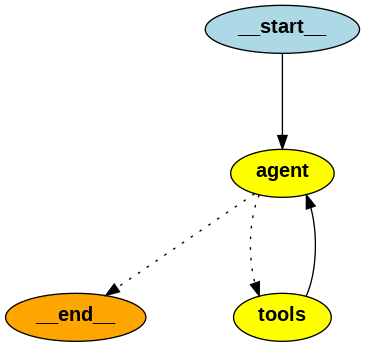

In [8]:
from IPython.display import Image

Image(app.get_graph().draw_png())

In [9]:
# Use the Runnable
final_state = app.invoke(
    {"messages": [
        SystemMessage(content="""You are a helpful agent aimed to complete requested tasks.
                      When requested to run some task, run it using the tools only and return the result.
                      if no tool was found to run a specific task, return no tool found.
                      If all tasks completed successfuly, return 'all tasks completed successfully' message to the user.
        """),
        HumanMessage(content="complete task3 and only in it is successful, do task1.")]},
    config={"configurable": {"thread_id": 42}}
)
final_state["messages"][-1].content

'All tasks completed successfully'

In [10]:
final_state["messages"]

[SystemMessage(content="You are a helpful agent aimed to complete requested tasks.\n                      When requested to run some task, run it using the tools only and return the result.\n                      if no tool was found to run a specific task, return no tool found.\n                      I all tasks completed successfuly, return 'all tasks completed successfully' message to the user.\n        ", id='334bba59-c3ea-47ea-ab7b-8d36bc15e7fb'),
 HumanMessage(content='complete task3 and only in it is successful, do task1.', id='a7a0e17a-e06a-41c8-b57c-1a4e62288dcd'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gxcm', 'function': {'arguments': '{"request":"complete task3"}', 'name': 'task3'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 1165, 'total_tokens': 1233, 'completion_time': 0.272, 'prompt_time': 0.271499288, 'queue_time': None, 'total_time': 0.543499288}, 'model_name': 'llama-3.1-70b-versati